In [ ]:
import csv
import torch
from transformers import BertTokenizer
import tensorflow as tf
# from torchtext.legacy import data
import pandas as pd
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import statistics
import math
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

In [ ]:
df = pd.read_csv("../text_patentability_data.csv")

In [ ]:
df

,claims,status
0,1-19. (Cancelled) 20. The mutant endotoxin mad...,ISS
1,1-41. (Canceled) 42. An isolated peptide havin...,ISS
2,1-23. (canceled) 24. An image processing devic...,ABN
3,1-36. (canceled) 37. The method of managing do...,ABN
4,1. A terminal comprising: a period reader read...,ISS
...,...,...
114023,1. A retractable roof in at least two elements...,ISS
114024,1. A stonecast product that is reinforced and ...,ISS
114025,"1. A kind of drug complex, with the feature th...",ABN
114026,1. Compounds with general formula I in which ...,ABN


In [ ]:
df = df[~df['status'].str.contains('PEND', case=False)]
df = df.reset_index(drop=True)
df

,claims,status
0,1-19. (Cancelled) 20. The mutant endotoxin mad...,ISS
1,1-41. (Canceled) 42. An isolated peptide havin...,ISS
2,1-23. (canceled) 24. An image processing devic...,ABN
3,1-36. (canceled) 37. The method of managing do...,ABN
4,1. A terminal comprising: a period reader read...,ISS
...,...,...
113276,1. A retractable roof in at least two elements...,ISS
113277,1. A stonecast product that is reinforced and ...,ISS
113278,"1. A kind of drug complex, with the feature th...",ABN
113279,1. Compounds with general formula I in which ...,ABN


In [ ]:
class_distribution = df['status'].value_counts()
percentage_distribution = (class_distribution / len(df)) * 100

print(percentage_distribution)
print(class_distribution)

ISS    66.942382
ABN    33.057618
Name: status, dtype: float64
ISS    75833
ABN    37448
Name: status, dtype: int64


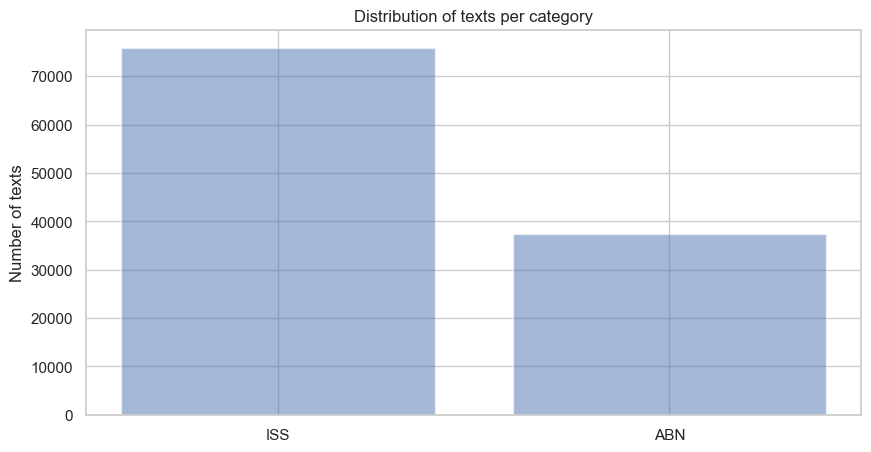

Counter({'ISS': 75833, 'ABN': 37448})


In [ ]:
classes = df[['status']].values.reshape(-1)

counter_classes = Counter(classes)
class_names = ["ISS", "ABN"]#, "idk"]
class_values = counter_classes.values()

y_pos = np.arange(len(class_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, class_values, align='center', alpha=0.5)
plt.xticks(y_pos, class_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_classes)

In [ ]:
#df['claims_split'] = df['claims'].apply(lambda x: x.split())

# Splitting the text column by spaces and finding the length of the split list
df['word_count'] = df['claims'].apply(lambda x: len(x.split()))
df['word_count'] = df['word_count'].astype(int)
# df.drop('claim_length', axis=1, inplace=True)

In [ ]:
df.iloc[0]

claims        1-19. (Cancelled) 20. The mutant endotoxin mad...
status                                                      ISS
word_count                                                  258
Name: 0, dtype: object

In [ ]:
global_summary_statistics = df['word_count'].describe()
global_summary_statistics

count    113281.000000
mean       1102.647620
std         991.317782
min           5.000000
25%         554.000000
50%         873.000000
75%        1350.000000
max       56481.000000
Name: word_count, dtype: float64

In [ ]:
# Calculating summary statistics for the word_count column per status class
summary_statistics_per_class = df.groupby('status')['word_count'].describe()
summary_statistics_per_class

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
ABN,37448.0,1015.160569,976.194379,6.0,498.0,795.0,1232.0,42528.0
ISS,75833.0,1145.850645,995.877167,5.0,585.0,913.0,1404.0,56481.0


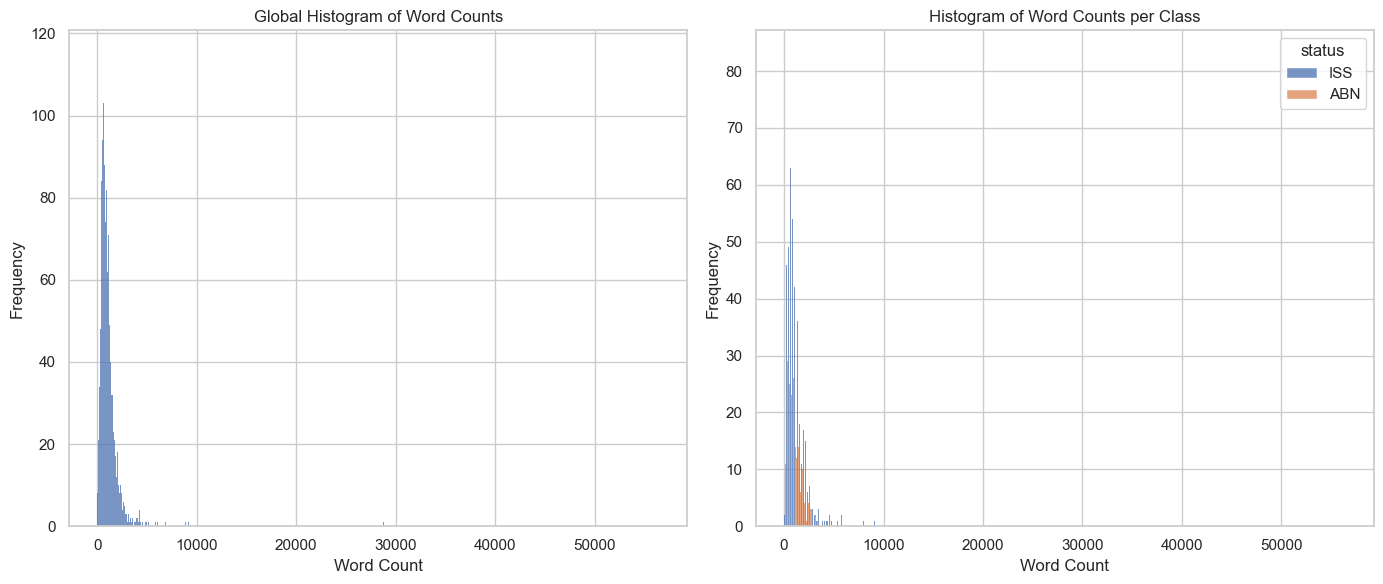

In [ ]:
# Creating a figure with two subplots
'''fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Global histogram of word counts
sns.histplot(df['word_count'], bins=range(1, df['word_count'].max() + 2), ax=axes[0], kde=False)
axes[0].set_title('Global Histogram of Word Counts')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

# Histogram of word counts per class
sns.histplot(data=df, x='word_count', hue='status', multiple="dodge",
             shrink=.8, bins=range(1, df['word_count'].max() + 2), ax=axes[1])
axes[1].set_title('Histogram of Word Counts per Class')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()'''

max_word_count = df['word_count'].max()

# Redefine the bins as a list of integers
bins = list(range(1, max_word_count + 2))

# Recreating the histograms with the adjusted bins and explicit float shrink value
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Global histogram of word counts
sns.histplot(df['word_count'], bins=bins, ax=axes[0], kde=False)
axes[0].set_title('Global Histogram of Word Counts')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

# Histogram of word counts per class
sns.histplot(data=df, x='word_count', hue='status', multiple="dodge",
             # shrink=0.8
              bins=bins, ax=axes[1])
axes[1].set_title('Histogram of Word Counts per Class')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

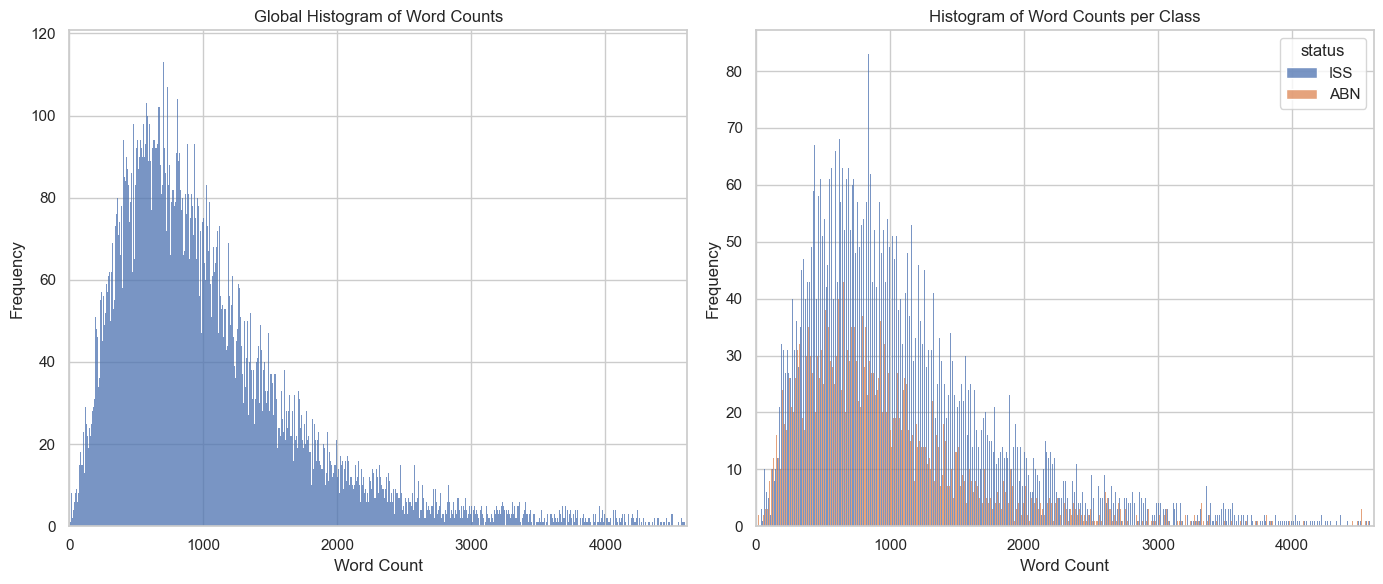

In [ ]:
# Set the x-axis limit to the 99th percentile to reduce whitespace
xlim_max = df['word_count'].quantile(0.99)

# Recreating the histograms with adjusted x-axis limits
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Global histogram of word counts with adjusted x-axis
sns.histplot(df['word_count'], bins=bins, ax=axes[0], kde=False)
axes[0].set_title('Global Histogram of Word Counts')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, xlim_max)  # Adjusting the x-axis limit

# Histogram of word counts per class with adjusted x-axis
sns.histplot(data=df, x='word_count', hue='status', multiple="dodge",
             bins=bins, ax=axes[1])
axes[1].set_title('Histogram of Word Counts per Class')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, xlim_max)  # Adjusting the x-axis limit

plt.tight_layout()
plt.show()


In [ ]:
# Iterate over rows
for index, row in df[:20].iterrows():
    print(row['claims'], row['status'])

1-19. (Cancelled) 20. The mutant endotoxin made according to the method of claim 32, wherein the mutant endotoxin is purified from the mutant non-typeable Haemophilus influenzae by phenol-water extraction or proteinase digestion. 21. (Cancelled) 22. The mutant non-typeable Haemophilus influenzae made according to the method of claim 34. 23-31. (Cancelled) 32. A method of making a mutant endotoxin comprising: culturing a non-typeable Haemophilus influenzae strain having a mutation in htrB gene, wherein the htrB mutation produces a mutant non-typeable Haemophilus influenzae having a mutant endotoxin containing a decreased phosphoethanolamine content and an increased hexose content in the mutant endotoxin's inner core, and a pentaacylated or tetraacylated lipid A lacking one or two secondary acyl chains compared to the corresponding wild-type non-typeable Haemophilus influenzae hexaacylated endotoxin, and wherein the mutant endotoxin has substantially reduced toxicity as compared to the h

In [ ]:
first_claim = df.iloc[0].claims #, df.iloc[0].status
first_claim

"1-19. (Cancelled) 20. The mutant endotoxin made according to the method of claim 32, wherein the mutant endotoxin is purified from the mutant non-typeable Haemophilus influenzae by phenol-water extraction or proteinase digestion. 21. (Cancelled) 22. The mutant non-typeable Haemophilus influenzae made according to the method of claim 34. 23-31. (Cancelled) 32. A method of making a mutant endotoxin comprising: culturing a non-typeable Haemophilus influenzae strain having a mutation in htrB gene, wherein the htrB mutation produces a mutant non-typeable Haemophilus influenzae having a mutant endotoxin containing a decreased phosphoethanolamine content and an increased hexose content in the mutant endotoxin's inner core, and a pentaacylated or tetraacylated lipid A lacking one or two secondary acyl chains compared to the corresponding wild-type non-typeable Haemophilus influenzae hexaacylated endotoxin, and wherein the mutant endotoxin has substantially reduced toxicity as compared to the 

In [ ]:
# Updated regular expression to better handle numbers, including decimals, but excluding trailing punctuation
numbers = re.findall(r'\d[\d,]*(?:\.\d+)?', first_claim)
print(numbers)

claim_refs_maybe = re.findall(r'method of claim \d[\d,]*(?:\.\d+)?', first_claim)
print(claim_refs_maybe)

cancelled = re.findall(r'\d+-\d+\. \(Cancelled\)|\d+\. \(Cancelled\)', first_claim)
print(cancelled)

['1', '19', '20', '32,', '21', '22', '34', '23', '31', '32', '33', '32', '34']
['method of claim 32,', 'method of claim 34', 'method of claim 32']
['1-19. (Cancelled)', '21. (Cancelled)', '23-31. (Cancelled)']


In [ ]:
from nltk.parse.corenlp import CoreNLPDependencyParser

In [ ]:
from stanfordcorenlp import StanfordCoreNLP
import logging
import json

class StanfordNLP:
    def __init__(self, host='http://localhost', port=9000):
        self.nlp = StanfordCoreNLP(host, port=port,
                                   timeout=30000)  # , quiet=False, logging_level=logging.DEBUG)
        self.props = {
            'annotators': 'tokenize,ssplit,pos,lemma,ner,parse,depparse,dcoref,relation',
            'pipelineLanguage': 'en',
            'outputFormat': 'json'
        }

    def word_tokenize(self, sentence):
        return self.nlp.word_tokenize(sentence)

    def pos(self, sentence):
        return self.nlp.pos_tag(sentence)

    def ner(self, sentence):
        return self.nlp.ner(sentence)

    def parse(self, sentence):
        return self.nlp.parse(sentence)

    def dependency_parse(self, sentence):
        return self.nlp.dependency_parse(sentence)

    def annotate(self, sentence):
        return json.loads(self.nlp.annotate(sentence, properties=self.props))

    @staticmethod
    def tokens_to_dict(_tokens):
        tokens = defaultdict(dict)
        for token in _tokens:
            tokens[int(token['index'])] = {
                'word': token['word'],
                'lemma': token['lemma'],
                'pos': token['pos'],
                'ner': token['ner']
            }
        return tokens

In [ ]:
sNLP = StanfordNLP()
text = "I want tacos now. A method of claim 2"
'''print("Annotate:", sNLP.annotate(text))
print("POS:", sNLP.pos(text))
print("Tokens:", sNLP.word_tokenize(text))
print("NER:", sNLP.ner(text))
print("Parse:", sNLP.parse(text))'''
print("Dep Parse:", sNLP.dependency_parse(text))

Dep Parse: [('ROOT', 0, 2), ('nsubj', 2, 1), ('obj', 2, 3), ('advmod', 2, 4), ('punct', 2, 5), ('ROOT', 0, 2), ('det', 2, 1), ('case', 4, 3), ('nmod', 2, 4), ('nummod', 4, 5)]


In [ ]:
const_result_1 =  sNLP.parse("I want tacos now, A method of claim 2")
print(const_result_1)

(ROOT
  (S
    (NP (PRP I))
    (VP (VBP want)
      (NP (NNS tacos))
      (ADVP (RB now))
      (, ,)
      (NP
        (NP (DT A) (NN method))
        (PP (IN of)
          (NP (NN claim) (CD 2)))))))


In [ ]:
const_result_2 =  sNLP.parse("The system of Claim 173, wherein at least one withdrawal or transfer from at least one client transaction account is made by wire or electronic transfer.")
print(const_result_2)


(ROOT
  (S
    (NP
      (NP
        (NP
          (NP (DT The) (NN system))
          (PP (IN of)
            (NP (NN Claim) (CD 173))))
        (, ,)
        (SBAR
          (WHADVP (WRB wherein))
          (FRAG
            (NP
              (QP
                (ADVP (IN at) (RBS least))
                (CD one))
              (NN withdrawal)))))
      (CC or)
      (NP
        (NP (NN transfer))
        (PP (IN from)
          (NP
            (NML
              (QP
                (ADVP (RB at) (RBS least))
                (CD one))
              (NN client))
            (NN transaction) (NN account)))))
    (VP (VBZ is)
      (VP (VBN made)
        (PP (IN by)
          (NP
            (NP (NN wire))
            (CC or)
            (NP (JJ electronic) (NN transfer))))))
    (. .)))


In [ ]:
# dep_result = sNLP.dependency_parse("I want tacos now. A method of claim 2")
const_result_3 = sNLP.parse("The transmission of claim 1, further comprising a hub cap bearing rotatably mounted over the longitudinal axis of the transmission and adapted to provide for relative movement between the bearing disc and the housing, and further adapted to transmit axial force to the case.")
print(const_result_3)

(ROOT
  (S
    (NP
      (NP (DT The) (NN transmission))
      (PP (IN of)
        (NP (NN claim) (CD 1))))
    (, ,)
    (ADVP (RB further))
    (VP (VBG comprising)
      (NP (DT a) (NN hub) (NN cap))
      (S
        (VP (VBG bearing)
          (S
            (S
              (ADVP (RB rotatably))
              (VP
                (VP (VBN mounted)
                  (PP (IN over)
                    (NP
                      (NP (DT the) (JJ longitudinal) (NN axis))
                      (PP (IN of)
                        (NP (DT the) (NN transmission))))))
                (CC and)
                (VP (VBD adapted)
                  (S
                    (VP (TO to)
                      (VP (VB provide)
                        (PP (IN for)
                          (NP
                            (NP (JJ relative) (NN movement))
                            (PP (IN between)
                              (NP
                                (NP (DT the) (NN bearing) (NN disc))
     

In [ ]:
const_result_4 = sNLP.parse("A method as set forth in Claim 1, wherein said step of using said beam comprises directing a particle beam at said Bose-Einstein condensate.")
print(const_result_4)

(ROOT
  (S
    (NP
      (NP (DT A) (NN method))
      (SBAR (IN as)
        (S
          (S
            (VP (VBN set)
              (ADVP (RB forth))
              (PP (IN in)
                (NP (NN Claim) (CD 1)))
              (, ,)
              (SBAR
                (WHADVP (WRB wherein))
                (S
                  (VP (VBD said)
                    (NP
                      (NP (NN step))
                      (PP (IN of)
                        (S
                          (VP (VBG using))))))))))
          (VP (VBD said)
            (SBAR
              (S
                (NP (NN beam))
                (VP (VBZ comprises)
                  (S
                    (VP (VBG directing)
                      (NP (DT a) (NN particle) (NN beam))
                      (PP (IN at)))))))))))
    (VP (VBD said)
      (NP
        (NP (NNP Bose) (HYPH -) (NNP Einstein))
        (NP (NN condensate))))
    (. .)))


In [ ]:
const_result_5 = sNLP.parse("At least one method as set forth in Claim 1, wherein said step of using said beam comprises directing a particle beam at said Bose-Einstein condensate.")
print(const_result_5)

(ROOT
  (S
    (NP
      (NP
        (QP
          (ADVP (IN At) (JJS least))
          (CD one))
        (NN method))
      (SBAR (IN as)
        (S
          (S
            (VP (VBN set)
              (ADVP (RB forth))
              (PP (IN in)
                (NP (NN Claim) (CD 1)))
              (, ,)
              (SBAR
                (WHADVP (WRB wherein))
                (S
                  (VP (VBD said)
                    (NP
                      (NP (NN step))
                      (PP (IN of)
                        (S
                          (VP (VBG using))))))))))
          (VP (VBD said)
            (SBAR
              (S
                (NP (NN beam))
                (VP (VBZ comprises)
                  (S
                    (VP (VBG directing)
                      (NP (DT a) (NN particle) (NN beam))
                      (PP (IN at)))))))))))
    (VP (VBD said)
      (NP
        (NP (NNP Bose) (HYPH -) (NNP Einstein))
        (NP (NN condensate))))
    (. .)))

In [ ]:
import nltk

# Convert the string to an NLTK Tree
constituency_tree_1 = nltk.tree.Tree.fromstring(const_result_1)
constituency_tree_2 = nltk.tree.Tree.fromstring(const_result_2)
constituency_tree_3 = nltk.tree.Tree.fromstring(const_result_3)
constituency_tree_4 = nltk.tree.Tree.fromstring(const_result_4)
constituency_tree_5 = nltk.tree.Tree.fromstring(const_result_5)

# Function to traverse the tree and find the matching subtree that contains a CD
def find_subtree_with_cd(tree):
    for subtree in tree.subtrees():
        if subtree.label() in ['S','NP',"VP"]: #and any(child.label() == 'CD' for child in subtree.subtrees()):
            if len(subtree) == 2 and subtree[0].label() == 'NN' and subtree[1].label() == 'CD':
                if subtree[0][0].lower() == 'claim':
                    # return subtree
                    # Return the subtree up to the last 'CD'
                    return cut_tree_at_cd(subtree)
    return None

def cut_tree_at_cd(tree):
    for pos in tree.treepositions():
        # Check if the current position points to a subtree, not a leaf
        if isinstance(tree[pos], nltk.Tree):
            if tree[pos].label() == 'CD':
                # Return the subtree up to this position, excluding 'CD'
                return tree[pos[:-1]]
    return tree



# Find the NP or VP subtree with CD
result_subtree = find_subtree_with_cd(constituency_tree_1)

# Print the result
if result_subtree:
    print(result_subtree)
    subtree_string = ' '.join(result_subtree.leaves())
    print(subtree_string)
else:
    print("Subtree with 'CD' not found")

(NP (NN claim) (CD 2))
claim 2


In [ ]:
import nltk
x = """(S
  (NP the/DT
      (AP little/JJ yellow/JJ)
       dog/NN)
  (VBD barked/VBD)
  (IN at/IN)
  (NP the/DT cat/NN))"""

pattern = """NP: {<DT>?<JJ>*<NN>}
VBD: {<VBD>}
IN: {<IN>}"""


def traverse_tree(tree, depth=float('inf')):
    """
    Traversing the Tree depth-first,
    yield leaves up to `depth` level.
    """
    for subtree in tree:
        if type(subtree) == nltk.tree.Tree:
            if subtree.height() <= depth:
                yield subtree.leaves()
                traverse_tree(subtree)


print(list(traverse_tree(nltk.tree.Tree.fromstring(x), 2)))

[['barked/VBD'], ['at/IN'], ['the/DT', 'cat/NN']]


'NPChunker = nltk.RegexpParser(pattern) \nresult = NPChunker.parse(sentence)\nresult'

In [ ]:
thousand_ex = df.iloc[1000].claims
thousand_ex

'1. A method of forming a multi-layer component, comprising: providing a multi-layer length of material in a solid state having a primary layer of thermoplastic material and at least one additional layer; zone heating at least one layer including the primary layer to create a molten zone portion in the at least one layer, leaving surrounding portions of the multi-layer length of material in a solid state; forcing the molten zone portion into a die cavity until the at least one layer takes the shape of the pressing unit and die cavity and forms a solid state section molded feature integral with the at least one layer; and cutting a length of material including the molded feature to a final shape. 2. The method of claim 1 the step of providing a primary layer of thermoplastic material further comprising: heating a polymeric compound and forcing the heated compound through an orifice to form a heated layer; and cooling the heated layer to form a primary layer in a solid state. 3. The meth

In [ ]:
thousand_ex_list = thousand_ex.split(".")
thousand_ex_list

['1',
 ' A method of forming a multi-layer component, comprising: providing a multi-layer length of material in a solid state having a primary layer of thermoplastic material and at least one additional layer; zone heating at least one layer including the primary layer to create a molten zone portion in the at least one layer, leaving surrounding portions of the multi-layer length of material in a solid state; forcing the molten zone portion into a die cavity until the at least one layer takes the shape of the pressing unit and die cavity and forms a solid state section molded feature integral with the at least one layer; and cutting a length of material including the molded feature to a final shape',
 ' 2',
 ' The method of claim 1 the step of providing a primary layer of thermoplastic material further comprising: heating a polymeric compound and forcing the heated compound through an orifice to form a heated layer; and cooling the heated layer to form a primary layer in a solid state

In [ ]:
for i in thousand_ex_list:
    constituency_tree_str = sNLP.parse(i)
    constituency_tree = nltk.tree.Tree.fromstring(constituency_tree_str)
    result_subtree = find_subtree_with_cd(constituency_tree)
    # Print the result
    if result_subtree:
        print(result_subtree)
        subtree_string = ' '.join(result_subtree.leaves())
        print(subtree_string)
    else:
        print("nah")


In [ ]:
claim_refs_maybe = re.findall(r'claim \d[\d,]*(?:\.\d+)?', thousand_ex)
print(claim_refs_maybe)